<a href="https://colab.research.google.com/github/kimyuji/EMNIST_Challenge/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import random
import pandas as pd
%matplotlib inline

## 0. Device Configuration and define Hyperparameters

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
input_size = 28 # EMNIST : 28*28*1
num_classes = 47 # label 종류
batch_size = 100 
num_epochs = 10
split_ratio = 0.1
learning_rate=0.001


## 1. Load data

In [ ]:
train_data = torchvision.datasets.EMNIST(
    root = './',
    split = 'bymerge',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor() 
    ])
)
test_data = torchvision.datasets.EMNIST(
    root = './',
    split = 'bymerge',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor() 
    ])
)

Extracting ./EMNIST/raw/emnist.zip to ./EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


## 2. Split train set and validation set

In [ ]:
data_size = len(train_data)
data_indices = list(range(data_size))
np.random.shuffle(data_indices) # shuffle하기
val_split_index = int(np.floor(0.2 * data_size))
train_idx, val_idx = data_indices[val_split_index:], data_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

## 3. Define dataloader

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler) #shuffle 필수

valid_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           sampler=val_sampler) #shuffle 필수

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
# cf) Check dataloader shape
image, label = next(iter(test_loader))
print(image.size()) # [Batch, Channel, Height, Width]  #batch_size=50으로 지정했음
print(label.size()) # 숫자이기 때문에 batch size인 50만 출력됨

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [ ]:
def image_show(dataset, num):
  fig = plt.figure(figsize=(30,30))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i][0].squeeze()) # input image
    plt.title(dataset[i][1]) # label : 0,1

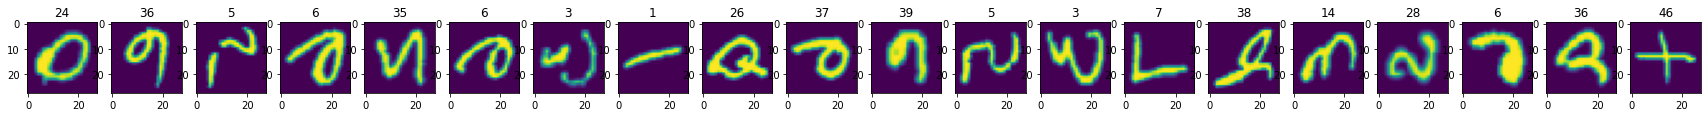

In [ ]:
image_show(train_data, 20)


## 4. Define a model

In [ ]:
class model2(nn.Module):
  def __init__(self):
    super(model2, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1), #edge, all info
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=50, kernel_size=5, stride=1, padding=1), # image의 특성
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=50, out_channels=100, kernel_size=5, stride=1, padding=1),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Sequential(
        nn.Linear(2*2*100, 200),
        nn.Linear(200,100),
        nn.Linear(100,47)
    )
  def forward(self, input):
      out = self.layer1(input)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.reshape(out.size(0), -1)
      out = self.dropout(out)
      out = self.fc(out)

      return out

model = model2().to(device)

In [ ]:
print(model)

model2(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=200, b

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

## 5. Define train and evaluate functions

In [ ]:
def train(model, train_loader, optimizer, criterion): 
  model.train() # train mode
  epoch_loss, acc, total = 0, 0, 0
  total_step = len(train_loader)
  for i, (image, label) in enumerate(train_loader):
    image = image.to(device)
    label = label.to(device)
    # Forward
    output = model(image)
    loss = criterion(output, label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    _, pred = torch.max(output.data, 1) 
    acc += (pred == label).sum().item()
    total += len(label)
  return epoch_loss/len(train_loader), acc / total * 100


In [ ]:
def evaluate(model, data_loader, criterion):
  model.eval() # evaluation mode
  with torch.no_grad(): #backprop 기능 끄기
    correct = 0
    epoch_loss = 0
    total=0
    for img, lab in data_loader:
      img = img.to(device)
      lab = lab.to(device)
      out = model(img)
      _, pred = torch.max(out.data,1) 
      correct += (pred == lab).sum().item()
      loss = criterion(out, lab)
      epoch_loss += loss.item()
      total += len(lab)
  return epoch_loss/len(data_loader), correct / total * 100 

## 6. Train the model

In [ ]:
print("----------------------- start training ---------------------------")
start = time.time() 
best_valid_loss = float('inf') # 무한대로 초기화
best_epoch = 0
train_error=[]
valid_error=[]
train_accuracy=[]
valid_accuracy=[]
for epoch in range(num_epochs):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
  train_error.append(train_loss)
  valid_error.append(valid_loss)
  train_accuracy.append(train_acc)
  valid_accuracy.append(valid_acc)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    best_epoch = epoch
    torch.save(model.state_dict(), "epoch_{}.pth".format(epoch+1))

  print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}, Valid Loss:{:.4f}, Valid Acc:{:.2f}".format(epoch+1, num_epochs, train_loss, train_acc, valid_loss, valid_acc))

result = pd.DataFrame([ x for x in zip(train_error, valid_error, train_accuracy, valid_accuracy)], 
                      index=[i+1 for i in range(num_epochs)],
                      columns=["train_error", "valid_error", "train_accuracy", "valid_accuracy"])
end = time.time() # 마지막 
print("Train takes {:.2f}minutes".format((end-start)/60)) # 시간 출력
print("----------------------- training ended ---------------------------")

----------------------- start training ---------------------------
Epoch[1/10], Train Loss:0.3926, Train Acc:86.48, Valid Loss:0.3217, Valid Acc:88.73
Epoch[2/10], Train Loss:0.3045, Train Acc:89.01, Valid Loss:0.2906, Valid Acc:89.42
Epoch[3/10], Train Loss:0.2824, Train Acc:89.68, Valid Loss:0.2824, Valid Acc:89.65
Epoch[4/10], Train Loss:0.2698, Train Acc:90.02, Valid Loss:0.2745, Valid Acc:89.92
Epoch[5/10], Train Loss:0.2604, Train Acc:90.28, Valid Loss:0.2704, Valid Acc:90.01
Epoch[6/10], Train Loss:0.2519, Train Acc:90.51, Valid Loss:0.2656, Valid Acc:90.25
Epoch[7/10], Train Loss:0.2452, Train Acc:90.65, Valid Loss:0.2668, Valid Acc:90.21
Epoch[8/10], Train Loss:0.2387, Train Acc:90.87, Valid Loss:0.2649, Valid Acc:90.25
Epoch[9/10], Train Loss:0.2338, Train Acc:91.00, Valid Loss:0.2699, Valid Acc:90.20
Epoch[10/10], Train Loss:0.2292, Train Acc:91.15, Valid Loss:0.2724, Valid Acc:90.09
Train takes 13.56minutes
----------------------- training ended ---------------------------


In [ ]:
model.load_state_dict(torch.load('./epoch_{}.pth'.format(best_epoch)))
torch.save(model.state_dict(), "model2.pth")

## 7. Check loss & accuracy function

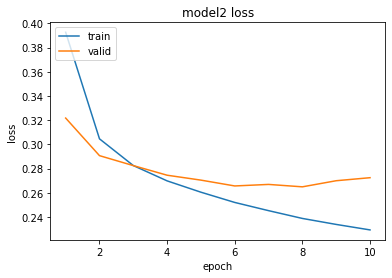

In [ ]:
plt.plot(result['train_error'])
plt.plot(result['valid_error'])
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

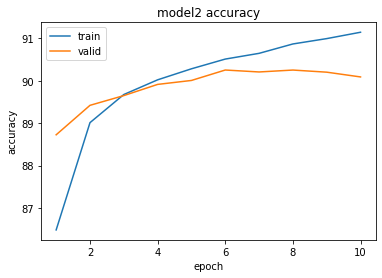

In [ ]:
plt.plot(result['train_accuracy'])
plt.plot(result['valid_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 8. Evaluate the model

In [ ]:
model.load_state_dict(torch.load('model2.pth'))

test_loss, test_acc = evaluate(model, test_loader, criterion)
print("Test Accuracy:{:.2f}% (Loss:{:.4f})".format(test_acc, test_loss))

Test Accuracy:90.35% (Loss:0.2668)


In [ ]:
print(best_epoch)

7
